This tutorial is about
- Define Heisenberg Hamiltonian
- Define CNN neural quantum state
- Symmetrize wave functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import quantax as qtx

lattice = qtx.sites.Square(4) # 4x4 square lattice
N = lattice.nsites

In [2]:
from quantax.symmetry import TotalSz, SpinInverse, C4v, Trans2D

# Heisenberg model with Marshall sign rule, default to nearest neighbor
# The lattice is implicitly passed as a global constant
H = qtx.operator.Heisenberg(msr=True)

# residual convolutional network with a summation for the final output
# 4 layers, 8 channels and 4x4 kernels
net = qtx.nn.ResSum(4, 8, 4)

state = qtx.state.Variational(
    net,
    symm=TotalSz(), # specify Sz = 0, important for Heisenberg model
    max_parallel=32768, # maximum forward batch on each machine
)

sampler = qtx.sampler.NeighborExchange(state, 1000)
tdvp = qtx.optimizer.TDVP(state, H)

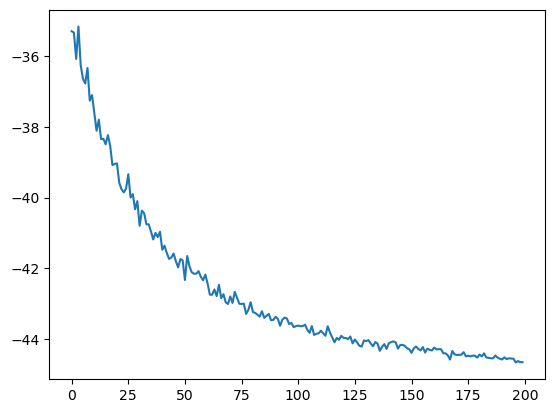

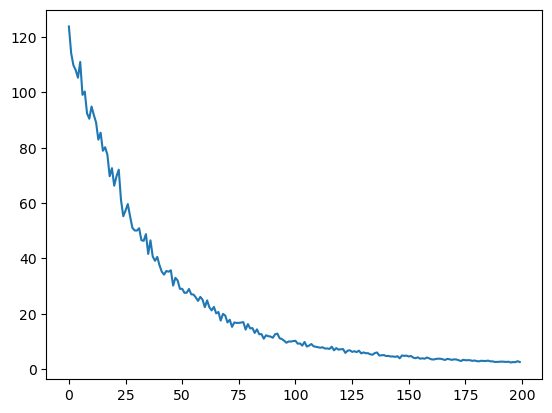

In [3]:
energy_data = qtx.utils.DataTracer()
VarE_data = qtx.utils.DataTracer()

for i in range(200):
    samples = sampler.sweep()
    step = tdvp.get_step(samples)
    state.update(step * 1e-3)
    energy_data.append(tdvp.energy)
    VarE_data.append(tdvp.VarE)

energy_data.plot()
plt.show()
VarE_data.plot()
plt.show()

Symmetrized NQS can provide much better performance

$\psi_\mathrm{symm}(s) = \frac{1}{|G|} \sum_g \omega_g^{-1} \psi(T_g s)$

for a symmetry group $\{g\}$ of order $|G|$ represented by operators $T_g$ with
characters $\omega_g$

In [5]:
# symmetrize the trained NQS

# no need to include translational symmetry, because it's encoded in CNN architecture
symm = TotalSz() + SpinInverse() + C4v()

# Symmetrization method 1
symm_state = qtx.state.Variational(
    state.ansatz, # the trained network
    symm=symm, # specify symmetry
    max_parallel=32768,
)

# Symmetrization method 2
state.save("/tmp/Heisenberg_params.eqx") # save as an equinox weight file
symm_state = qtx.state.Variational(
    net, # the same network
    param_file="/tmp/Heisenberg_params.eqx", # load weights
    symm=symm, # specify symmetry
    max_parallel=32768,
)

# Symmetrization method 3
symm_state = symm(state)

sampler = qtx.sampler.NeighborExchange(symm_state, 1000)
tdvp = qtx.optimizer.TDVP(symm_state, H)

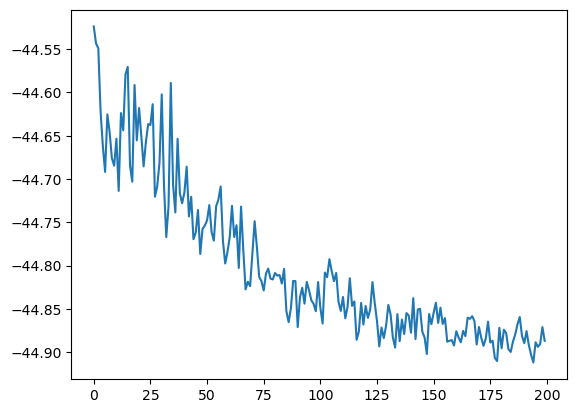

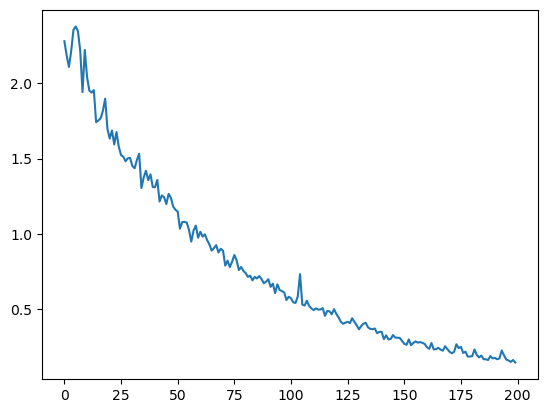

In [6]:
energy_data = qtx.utils.DataTracer()
VarE_data = qtx.utils.DataTracer()

for i in range(200):
    samples = sampler.sweep()
    step = tdvp.get_step(samples)
    symm_state.update(step * 1e-3)
    energy_data.append(tdvp.energy)
    VarE_data.append(tdvp.VarE)

energy_data.plot()
plt.show()
VarE_data.plot()
plt.show()

In [7]:
# check result by ED
full_symm = symm + Trans2D()
E, wf = H.diagonalize(full_symm)
print(E[0])

/home/locao/miniconda3/envs/netket/lib/python3.9/site-packages/quantax/symmetry/symmetry.py:126: GeneralBasisWarning: using non-commuting symmetries can lead to unwanted behaviour of general basis, make sure that quantum numbers are invariant under non-commuting symmetries!
  basis = spin_basis_general(


Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
-44.91393283371545
